<a href="https://colab.research.google.com/github/mpgl/dendrify-paper/blob/main/Fig4-notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Overview
> *In this interactive Python notebook, we present and briefly discuss the code needed to replicate the model and the results shown in Figure 4 of the manuscript. In this example our goal is to illustrate:*
>
> - *More Dendrify features that allow modelling dendritic voltage-gated ion channels (VGICs) phenomenologically without using the Hodgkin-Huxley equations.*
>
> - *That with Dendrify it is possible to create simplified compartmental integrate and fire (I&F) models reproducing numerous biological dendritic functions.*
>
>
> <hr>
>
> *__Note__: In case you are unfamiliar with how Python notebooks work and you would like to run or rerun the entire code, simply select one of the options bellow:*
>
> - **Runtime ➝ Run all**
> - **Runtime ➝ Restart and run all**
>
> *located on the top menu and wait a few seconds until all cells finish running.*
> <hr>
>
> *All source code of the current Dendrify version is available on* [GitHub](https://github.com/mpgl/dendrify-paper)

## Setup

In [1]:
#@title Install dependencies (might take a few seconds)
import os
if 'dendrify' in os.getcwd():
    pass
else:
    !git clone https://github.com/mpgl/dendrify-paper.git --quiet
    os.chdir('dendrify-paper')

!pip install brian2 --quiet

fatal: destination path 'dendrify-paper' already exists and is not an empty directory.


In [2]:
#@title Imports and settings
import brian2 as b
from brian2.units import (ms, um, pA, nS, uS, ohm, cm, mV, uF, mvolt) # Generally a better practise than * imports
from dendrify import Soma, Dendrite, NeuronModel

b.prefs.codegen.target = 'numpy' # Improves performance significantly here
b.start_scope()    # allows running separate simulations in the same notebook

# @title Figure settings
blue = '#005c94ff'
green = '#338000ff'
orange = '#ff6600ff'
notred = '#aa0044ff'
params = {
          "legend.fontsize": 10,
          "legend.handlelength": 1.5,
          "legend.edgecolor": 'inherit',
          "legend.columnspacing": 0.8,
          "legend.handletextpad": 0.5,
          "axes.labelsize": 10,
          "axes.titlesize": 11, 
          "axes.spines.right": False,
          "axes.spines.top": False,
          "xtick.labelsize": 10,
          "ytick.labelsize": 10,
          'mathtext.default': 'regular',
          'lines.markersize': 3,
          'lines.linewidth': 1.25,
          'grid.color': "#d3d3d3",
          'text.antialiased': True,
          'lines.antialiased': True,
          'figure.dpi': 150,
          'axes.prop_cycle': b.cycler(color=[blue, green, orange, notred])
          }

b.rcParams.update(params)

## Build model
> *Let's first creat a 4-compartment toy model with active dendritic mechanism:*

In [3]:
# create soma
soma = Soma('soma', model='leakyIF', length=25*um, diameter=25*um )

# create trunk
trunk = Dendrite('trunk', length=100*um, diameter=2.5*um)
trunk.dspikes('Na', threshold=-35*mV, g_rise=34*nS, g_fall=27.2*nS)

# create proximal dendrite
prox = Dendrite('prox', length=100*um, diameter=1*um)
prox.synapse('AMPA', pre='pathY', g=0.8*nS,  t_decay=2*ms)
prox.synapse('NMDA', pre='pathY', g=0.8*nS,  t_decay=60*ms)
prox.dspikes('Na', threshold=-35*mV, g_rise=15.3*nS, g_fall=12.24*nS)

# create distal dendrite
dist = Dendrite('dist', length=100*um, diameter=0.5*um)
dist.synapse('AMPA', pre='pathX', g=0.8*nS,  t_decay=2*ms)
dist.synapse('NMDA', pre='pathX', g=0.8*nS,  t_decay=60*ms)
dist.dspikes('Na', threshold=-35*mV, g_rise=7*nS, g_fall=5.6*nS)

# merge compartments into a  neuron model and set its basic properties
edges = [(soma, trunk, 15*nS), (trunk, prox, 10*nS), (prox, dist, 4*nS)]
pyr_model = NeuronModel(edges, cm=1*uF/(cm**2), gl=40*uS/(cm**2),
                        v_rest=-70*mV, r_axial=150*ohm*cm,
                        scale_factor=2.8, spine_factor=1.5)

# set Na spikes properties
pyr_model.dspike_properties('Na', tau_rise=0.6*ms, tau_fall=1.2*ms,
                            refractory=5*ms, offset_fall=0.2*ms)

# create a Brian NeuronGroup and link it to the neuron model
pyr_group = b.NeuronGroup(3, model=pyr_model.equations, method='euler',
                          threshold='V_soma > -40*mV', reset='V_soma = 40*mV',
                          refractory=4*ms, events=pyr_model.events,
                          namespace=pyr_model.parameters)
pyr_model.link(pyr_group)

# a little trick for having somatic spikes with more realistic shape which also
# allows the generation of backpropagating dendritic spikes
second_reset = b.Synapses(pyr_group, pyr_group, on_pre='V_soma=-55*mV', delay=0.5*ms)
second_reset.connect(j='i')

> *We can inspect what Dendrify did for us by simply printing the NeuronModel object we created. As we see, compared to the model shown in Fig. 2, this model is significantly more complex.*

In [4]:
print(pyr_model)

OBJECT TYPE:

  <class 'dendrify.neuronmodel.NeuronModel'>

---------------------------------------------

PROPERTIES (type): 

→ equations (str):
    dV_soma/dt = (gL_soma * (EL_soma-V_soma) + I_soma) / C_soma  :volt
    I_soma = I_ext_soma + I_trunk_soma   :amp
    I_ext_soma  :amp
    I_trunk_soma = (V_trunk-V_soma) * g_trunk_soma  :amp
    
    dV_trunk/dt = (gL_trunk * (EL_trunk-V_trunk) + I_trunk) / C_trunk  :volt
    I_trunk = I_ext_trunk + I_prox_trunk  + I_soma_trunk  + I_Na_trunk + I_Kn_trunk  :amp
    I_ext_trunk  :amp
    I_Na_trunk = g_Na_trunk * (E_Na-V_trunk)  :amp
    I_Kn_trunk = g_Kn_trunk * (E_K-V_trunk)  :amp
    dg_Na_trunk/dt = -g_Na_trunk/tau_Na  :siemens
    dg_Kn_trunk/dt = -g_Kn_trunk/tau_Kn  :siemens
    allow_I_Na_trunk  :boolean
    allow_I_Kn_trunk  :boolean
    timer_Na_trunk  :second
    I_soma_trunk = (V_soma-V_trunk) * g_soma_trunk  :amp
    I_prox_trunk = (V_prox-V_trunk) * g_prox_trunk  :amp
    
    dV_prox/dt = (gL_prox * (EL_prox-V_prox) + I_prox)

> *Our model now looks somewhat like this:*
>
><p align="center">
    <img src="https://github.com/mpgl/dendrify-paper/blob/main/graphics/2.png?raw=true" alt="model" width="25%">
></p>
>
> *Let's use it to replicate the experiments shown in Figure 4.*

## Panels b-e | dSpike initiation and propagation
> *To test the impact of locally generated Na+ spikes on dendritic and somatic responses we simulated the application of short current injections (5 ms long pulses of rheobase intensity) to each dendritic segment and recorded the voltage responses of all compartments.*

In [5]:
# Set monitors to record membrane voltages
vars = ["V_soma", "V_trunk", "V_prox", "V_dist"]
M = b.StateMonitor(pyr_group, vars, record=True)

# First 5 ms -> no input
b.run(5*ms)

# Next 5 ms -> square pulse for crossing dSpike threshold
pyr_group.I_ext_dist[0] = 123 * pA
pyr_group.I_ext_prox[1] = 309 * pA
pyr_group.I_ext_trunk[2] = 560 * pA
b.run(5*ms)

# Next 40 ms -> no input to let membranes return closer to Vrest
pyr_group.I_ext_dist[0] = 0 * pA
pyr_group.I_ext_prox[1] = 0 * pA
pyr_group.I_ext_trunk[2] = 0 * pA
b.run(40*ms)

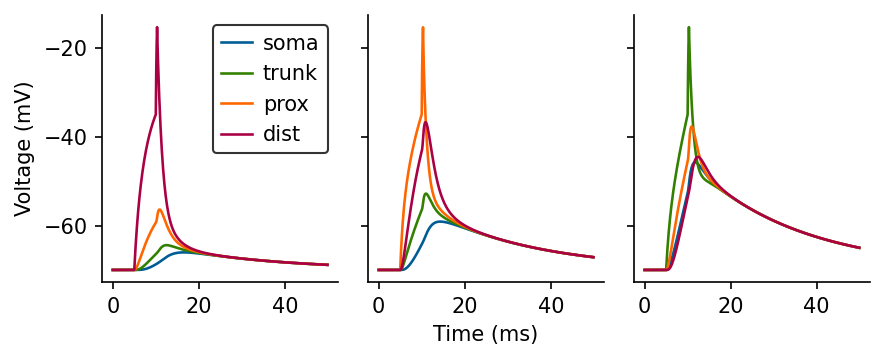

In [6]:
#@title Plot voltage traces
time = M.t/ms
vs = M.V_soma/mV
vt = M.V_trunk/mV
vp = M.V_prox/mV
vd = M.V_dist/mV

fig, axes = b.subplots(1, 3, figsize=[6,2.5], sharex=True, sharey=True)
ax0, ax1, ax2 = axes

for id, ax in enumerate(axes):
    for v, l in zip([vs, vt, vp, vd], ['soma', 'trunk', 'prox', 'dist']):
        ax.plot(time, v[id], label=l)

ax0.legend()
ax0.set_ylabel('Voltage (mV)')
ax1.set_xlabel('Time (ms)')
fig.tight_layout()

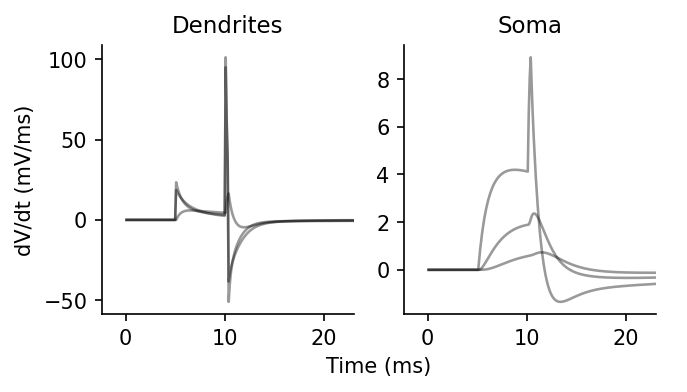

In [7]:
#@title Plot first temporal derivatives
fig, axes = b.subplots(1, 2, figsize=[5, 3], sharex=True)
ax0, ax1 = axes
secret_ax = fig.add_subplot(111, frameon=False)
secret_ax.tick_params(labelcolor='none', which='both', bottom=False, left=False)


steps = b.arange(0.1, 50, 0.1)
dvdt_dist =  b.diff(vd[0]) / (0.1)
dvdt_prox =  b.diff(vp[1]) / (0.1)
dvdt_trunk =  b.diff(vp[2]) / (0.1)
dvdt_som0 =  b.diff(vs[0]) / (0.1)
dvdt_som1 =  b.diff(vs[1]) / (0.1)
dvdt_som2 =  b.diff(vs[2]) / (0.1)

for dend, som in zip([dvdt_dist, dvdt_prox, dvdt_trunk],
                     [dvdt_som0, dvdt_som1, dvdt_som2]):
    ax0.plot(steps, dend, alpha=0.4, c='black')
    ax1.plot(steps, som, alpha=0.4, c='black')

ax0.set_xlim(right=23)
ax0.set_ylabel('dV/dt (mV/ms)')
ax0.set_title('Dendrites')
ax1.set_title('Soma')
secret_ax.set_xlabel('Time (ms)')
fig.tight_layout()

> *Although model parameters were adjusted to elicit nearly identical dSpikes in all dendrites, somatic responses varied significantly, depending on the dSpike initiation site. As in real neurons, distal dSpikes became much weaker and broader as they travel towards the soma due to the dendritic filtering effect.*

## Panel f | Input-output functions
> *To examine how dendritic spiking combined with local branch properties affect synaptic integration, we will activate quasi-simultaneously (train of spikes with ISI 0.1 ms) an increasing number of synapses placed on the distal and the proximal segments. We will then compared the peak amplitude of the dendritic voltage responses (Actual) to what would be obtained by a linear arithmetic sum of unitary responses (Expected).*

In [20]:
# create a new Brian NeuronGroup and link it to the existing NeuronModel
b.start_scope()    # allows running separate simulations in the same notebook
b.defaultclock.dt = 0.05*ms    # increase the simulation accuracy  
Nsyn = 15
# create a Brian NeuronGroup and link it to the neuron model
pyr_group2 = b.NeuronGroup(Nsyn, model=pyr_model.equations, method='euler',
                          threshold='V_soma > -40*mV', reset='V_soma = 40*mV',
                          refractory=4*ms, events=pyr_model.events,
                          namespace=pyr_model.parameters)
pyr_model.link(pyr_group2)

# synaptic protocol
start = 5*ms
isi = 0.1*ms
    
spiketimes = [(start + (i*isi)) for i in range(Nsyn)]
I = b.SpikeGeneratorGroup(Nsyn, range(Nsyn), spiketimes)

synaptic_effect = "s_AMPA_pathX_dist += 1.0; s_NMDA_pathX_dist += 1.0"
S = b.Synapses(I, pyr_group2, on_pre=synaptic_effect)
S.connect('j >= i')

# Set monitors to record membrane voltages and run simulation
M = b.StateMonitor(pyr_group2, ["V_dist"], record=True)
b.run(150 *ms)

vd = M.V_dist/mV


In [21]:
# create a new Brian NeuronGroup and link it to the existing NeuronModel
b.start_scope()    # allows running separate simulations in the same notebook
b.defaultclock.dt = 0.05*ms    # increase the simulation accuracy  
Nsyn = 15
# create a Brian NeuronGroup and link it to the neuron model
pyr_group3 = b.NeuronGroup(Nsyn, model=pyr_model.equations, method='euler',
                          threshold='V_soma > -40*mV', reset='V_soma = 40*mV',
                          refractory=4*ms, events=pyr_model.events,
                          namespace=pyr_model.parameters)
pyr_model.link(pyr_group3, automate='v_rest')

# synaptic protocol
start = 5*ms
isi = 0.1*ms
    
spiketimes = [(start + (i*isi)) for i in range(Nsyn)]
I = b.SpikeGeneratorGroup(Nsyn, range(Nsyn), spiketimes)

synaptic_effect = "s_AMPA_pathX_dist += 1.0; s_NMDA_pathX_dist += 1.0"
S = b.Synapses(I, pyr_group3, on_pre=synaptic_effect)
S.connect('j >= i')

# Set monitors to record membrane voltages and run simulation
M = b.StateMonitor(pyr_group3, ["V_dist"], record=True)
b.run(150 *ms)

vd_ttx = M.V_dist/mV


In [26]:
time = M.t/ms

peaks = [max(v)+70 for v in vd]
unitary = peaks[0]
expected = b.linspace(1, Nsyn, Nsyn) * unitary


peaks_ttx = [max(v)+70 for v in vd_ttx]
unitary_ttx = peaks_ttx[0]
expected_ttx = b.linspace(1, Nsyn, Nsyn) * unitary_ttx


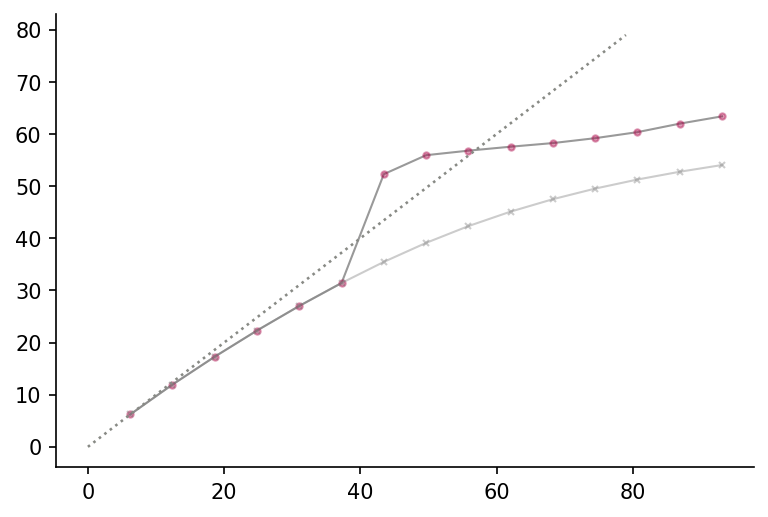

In [30]:
b.plot(expected, peaks, "o-", ms=3, c='black', lw=1, mfc='#aa0044ff',
          mec='#aa0044ff', alpha=0.4, label='control')
b.plot(expected_ttx, peaks_ttx, "x-", ms=3, c='gray', lw=1, alpha=0.4, label='OFF')
b.plot(range(80), range(80), c='#888a85ff', ls=':' )